In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import InceptionV3
import xml.etree.ElementTree as ET
import os



In [ ]:
def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    bndbox = root.find('.//bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    return (xmin, ymin, xmax, ymax)

def load_images(*folders):
    all_images = []
    all_labels = []
    for i, folder in enumerate(folders):
        images = []
        folder = folder.replace("\\", "/")
        annotation_classes = folder.split("/")[-1]
        annotation_folder = os.path.join('/content/drive/MyDrive/dogs multi/annotations', annotation_classes)
        print(f"Loading images from folder: {folder}")
        print(f"Annotation folder: {annotation_folder}")

        for image, annotation in zip(os.listdir(folder), os.listdir(annotation_folder)):
            img_path = os.path.join(folder, image)
            annotation_path = os.path.join('/content/drive/MyDrive/dogs multi/annotations', annotation_classes, annotation)

            print(f"Image path: {img_path}")
            print(f"Annotation path: {annotation_path}")

            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:
                print(f"Failed to read image: {img_path}")
                continue

            bndbox = parse_annotation(annotation_path)
            xmin, ymin, xmax, ymax = bndbox

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img[ymin:ymax, xmin:xmax]

            if img.size == 0:
                print(f"Empty ROI in image: {img_path}")
                continue

            img = cv2.resize(img, (250, 250))
            images.append(img)

        labels = np.full(len(images), i)
        all_images.extend(images)
        all_labels.extend(labels)

    return np.array(all_images), np.array(all_labels),len(set(all_labels))


images, labels,num_classes = load_images(r"/content/drive/MyDrive/dogs multi/n02085936-Maltese_dog",
                                         r"/content/drive/MyDrive/dogs multi/n02091831-Saluki",
                                         r"/content/drive/MyDrive/dogs multi/n02095570-Lakeland_terrier",
                                         r"/content/drive/MyDrive/dogs multi/n02106662-German_shepherd",
                                         r"/content/drive/MyDrive/dogs multi/n02108000-EntleBucher",
                                         r"/content/drive/MyDrive/dogs multi/n02108089-boxer",
                                         r"/content/drive/MyDrive/dogs multi/n02109047-Great_Dane",
                                         r"/content/drive/MyDrive/dogs multi/n02113978-Mexican_hairless",
                                         r"/content/drive/MyDrive/dogs multi/n02115913-dhole",
                                         r"/content/drive/MyDrive/dogs multi/n02116738-African_hunting_dog")

Loading images from folder: /content/drive/MyDrive/dogs multi/n02085936-Maltese_dog
Annotation folder: /content/drive/MyDrive/dogs multi/annotations/n02085936-Maltese_dog
Image path: /content/drive/MyDrive/dogs multi/n02085936-Maltese_dog/n02085936_548 (1).jpg
Annotation path: /content/drive/MyDrive/dogs multi/annotations/n02085936-Maltese_dog/n02085936_10397
Image path: /content/drive/MyDrive/dogs multi/n02085936-Maltese_dog/n02085936_5435 (1).jpg
Annotation path: /content/drive/MyDrive/dogs multi/annotations/n02085936-Maltese_dog/n02085936_10719
Image path: /content/drive/MyDrive/dogs multi/n02085936-Maltese_dog/n02085936_5435.jpg
Annotation path: /content/drive/MyDrive/dogs multi/annotations/n02085936-Maltese_dog/n02085936_10130
Image path: /content/drive/MyDrive/dogs multi/n02085936-Maltese_dog/n02085936_5466 (1).jpg
Annotation path: /content/drive/MyDrive/dogs multi/annotations/n02085936-Maltese_dog/n02085936_10073
Image path: /content/drive/MyDrive/dogs multi/n02085936-Maltese_do

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/10
23/23 [==============================] - 114s 5s/step - loss: 0.8473 - accuracy: 0.6745
Epoch 2/10
23/23 [==============================] - 101s 4s/step - loss: 0.2773 - accuracy: 0.9090
Epoch 3/10
23/23 [==============================] - 97s 4s/step - loss: 0.1646 - accuracy: 0.9379
Epoch 4/10
23/23 [==============================] - 97s 4s/step - loss: 0.1090 - accuracy: 0.9669
Epoch 5/10
23/23 [==============================] - 94s 4s/step - loss: 0.0755 - accuracy: 0.9779
Epoch 6/10
23/23 [==============================] - 102s 4s/step - loss: 0.0632 - accuracy: 0.9821
Epoch 7/10
23/23 [==============================] - 98s 4s/step - loss: 0.0598 - accuracy: 0.9862
Epoch 8/10
23/23 [==============================] - 98s 4s/step - loss: 0.0352 - accuracy: 0.9945
Epoch 9/10
23/23 [==============================] - 99s 4s/step - loss: 0.0320 - accuracy: 0.9917
Epoch 10/10
6/6 [==============================] -

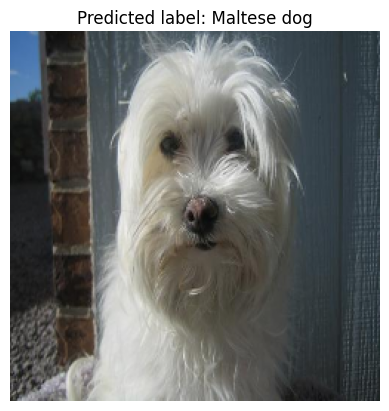

1/1 [==============================] - 0s 141ms/step


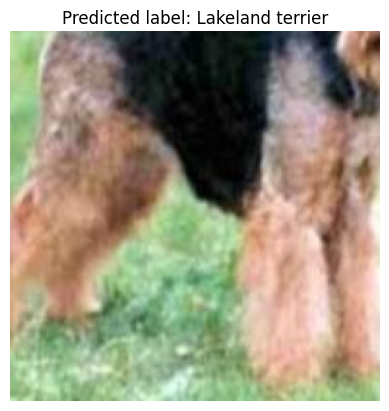

1/1 [==============================] - 0s 154ms/step


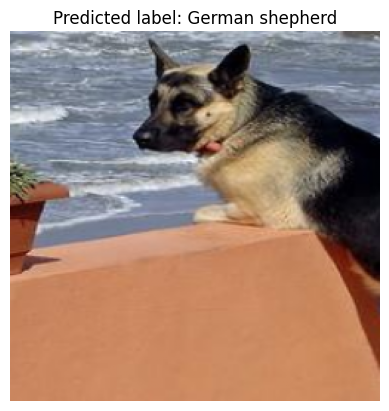

1/1 [==============================] - 0s 146ms/step


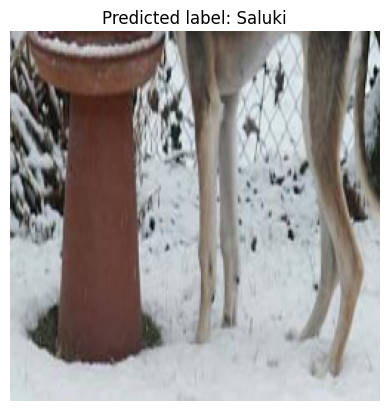

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train = X_train / 255.0
X_test = X_test / 255.0

base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(250, 250, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(renorm=True),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32)

loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

breed_names = ['Maltese dog', 'Saluki', 'Lakeland terrier', 'German shepherd', 'EntleBucher', 'Boxer', 'Great Dane', 'Mexican hairless', 'Dhole', 'African hunting dog']

def predict(index):
    predicted_prob = model.predict(X_test[[index]])
    predicted_label_index = np.argmax(predicted_prob)
    predicted_label = breed_names[predicted_label_index]
    plt.figure()
    plt.imshow(X_test[index])
    plt.title('Predicted label: ' + predicted_label)
    plt.axis("off")
    plt.show()

predict(100)
predict(19)
predict(67)
predict(74)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
